In [1]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

scene_id=365 scene_name=scene-0451 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:365: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


odom_speed [[1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.30000000e+01]
 ...
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


self.dir_name images/365/database


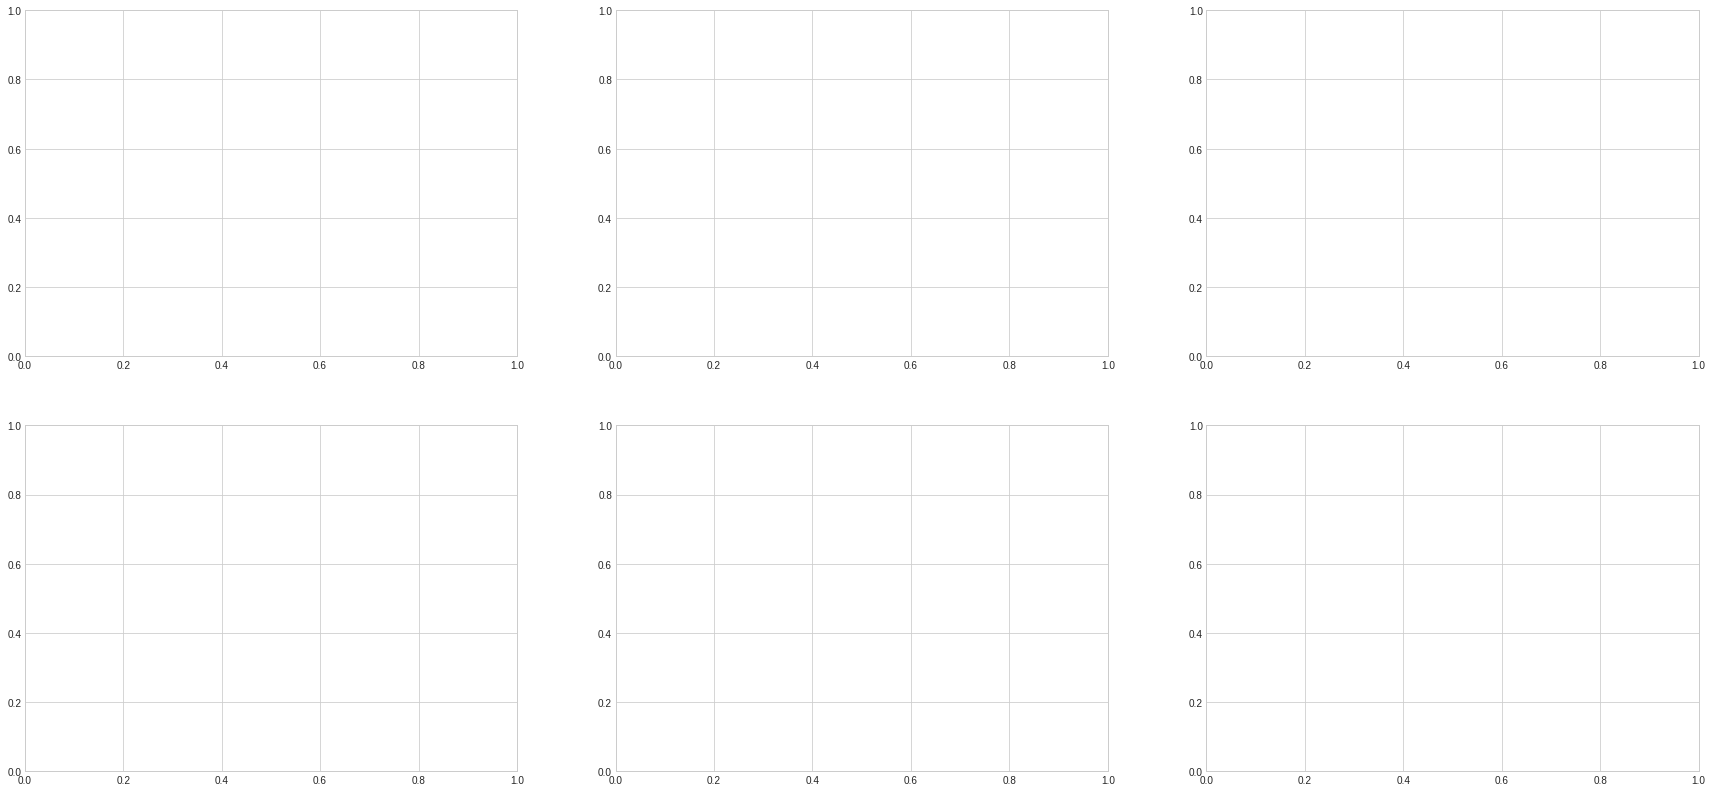

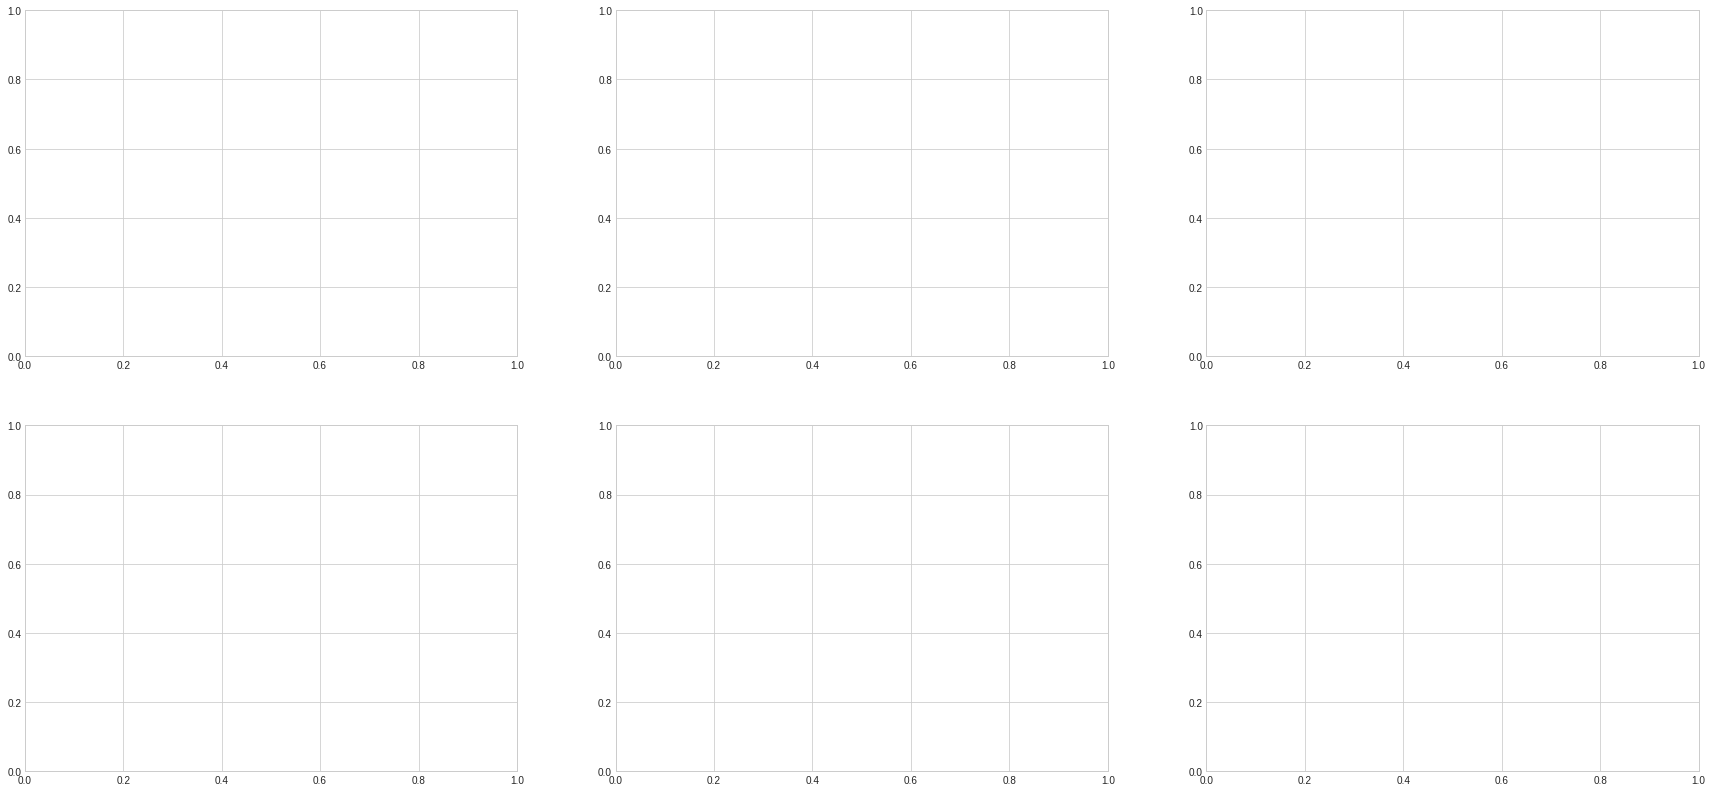

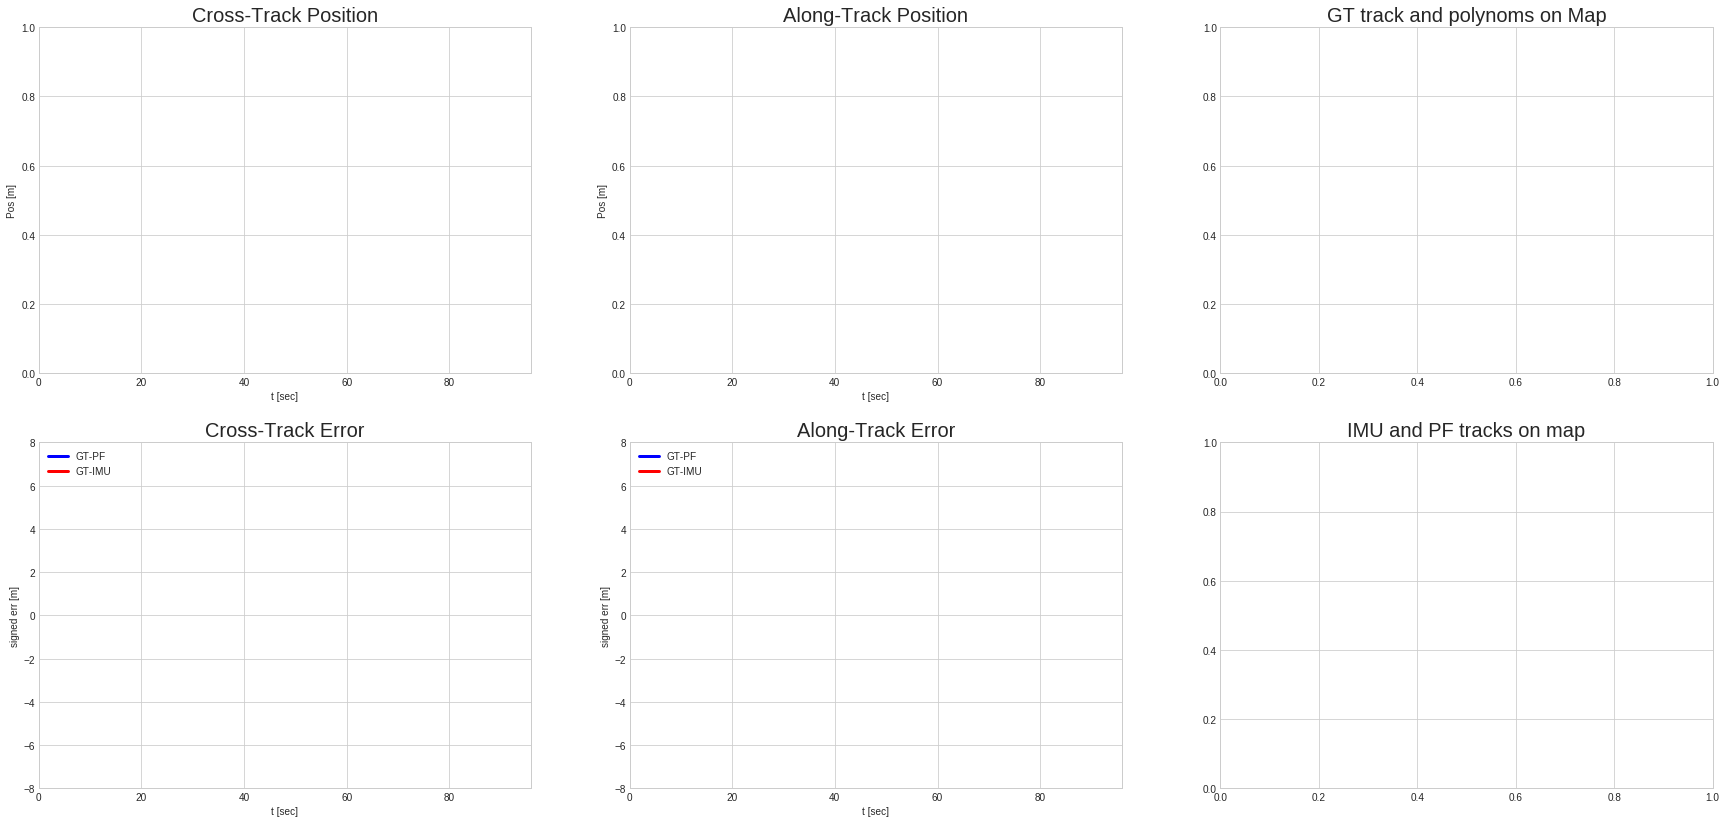

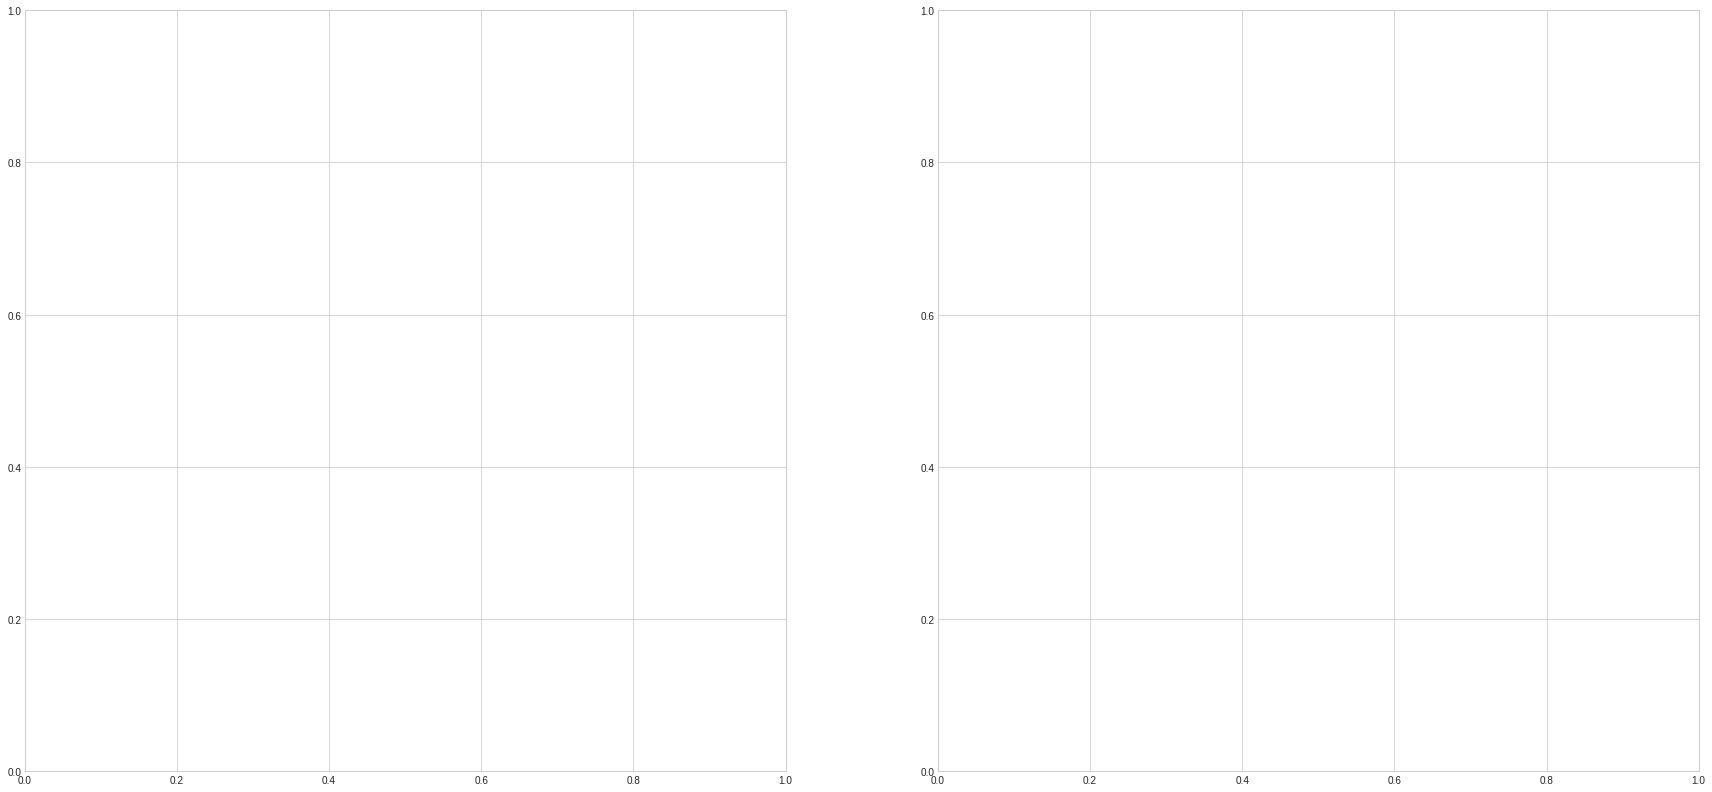

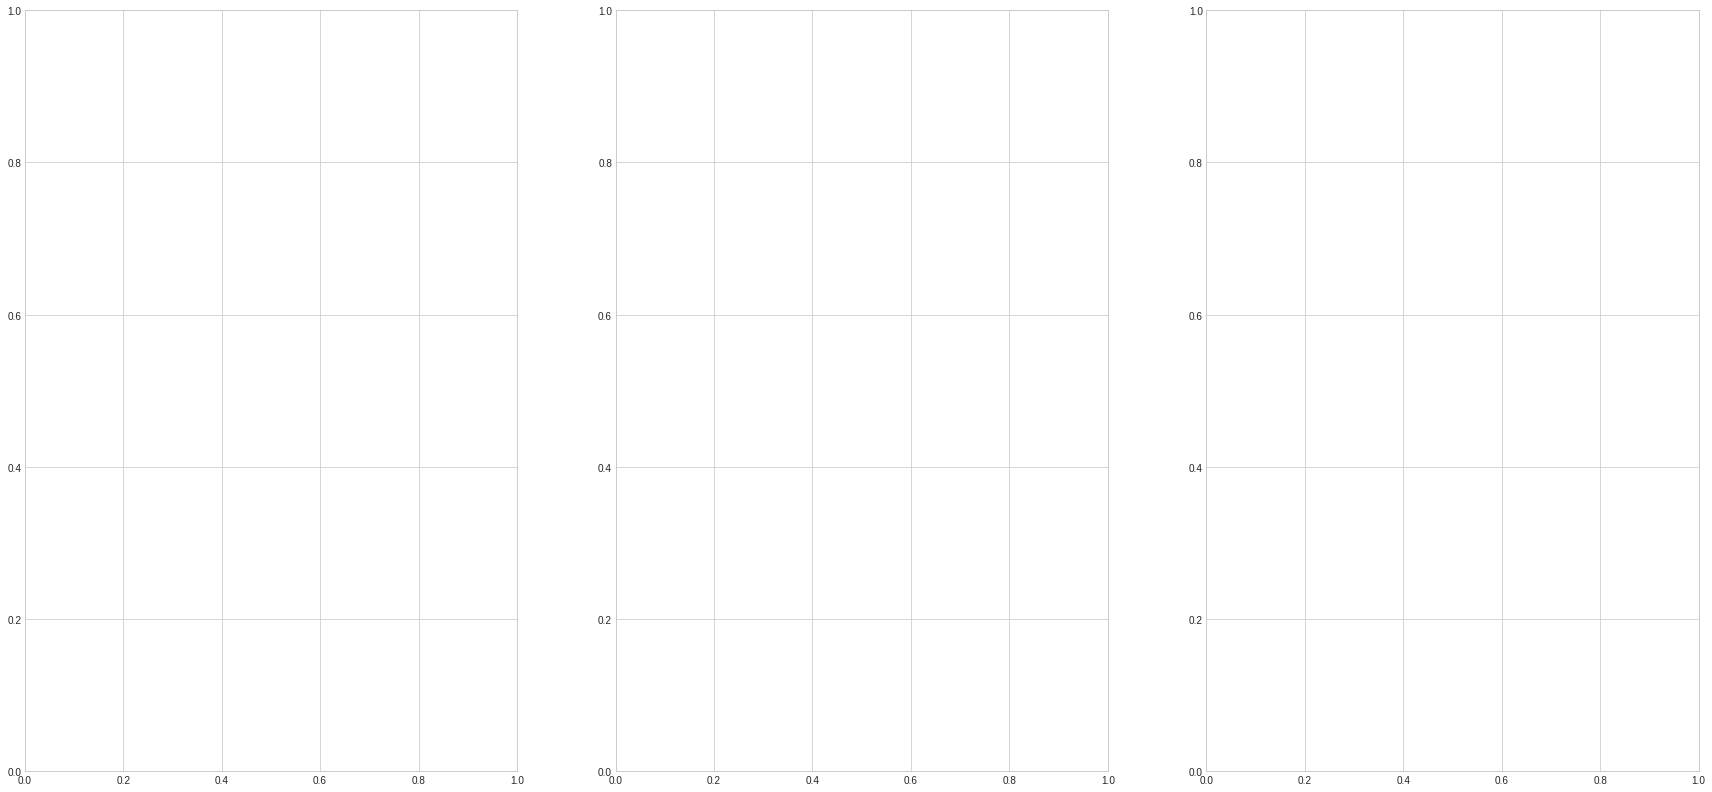

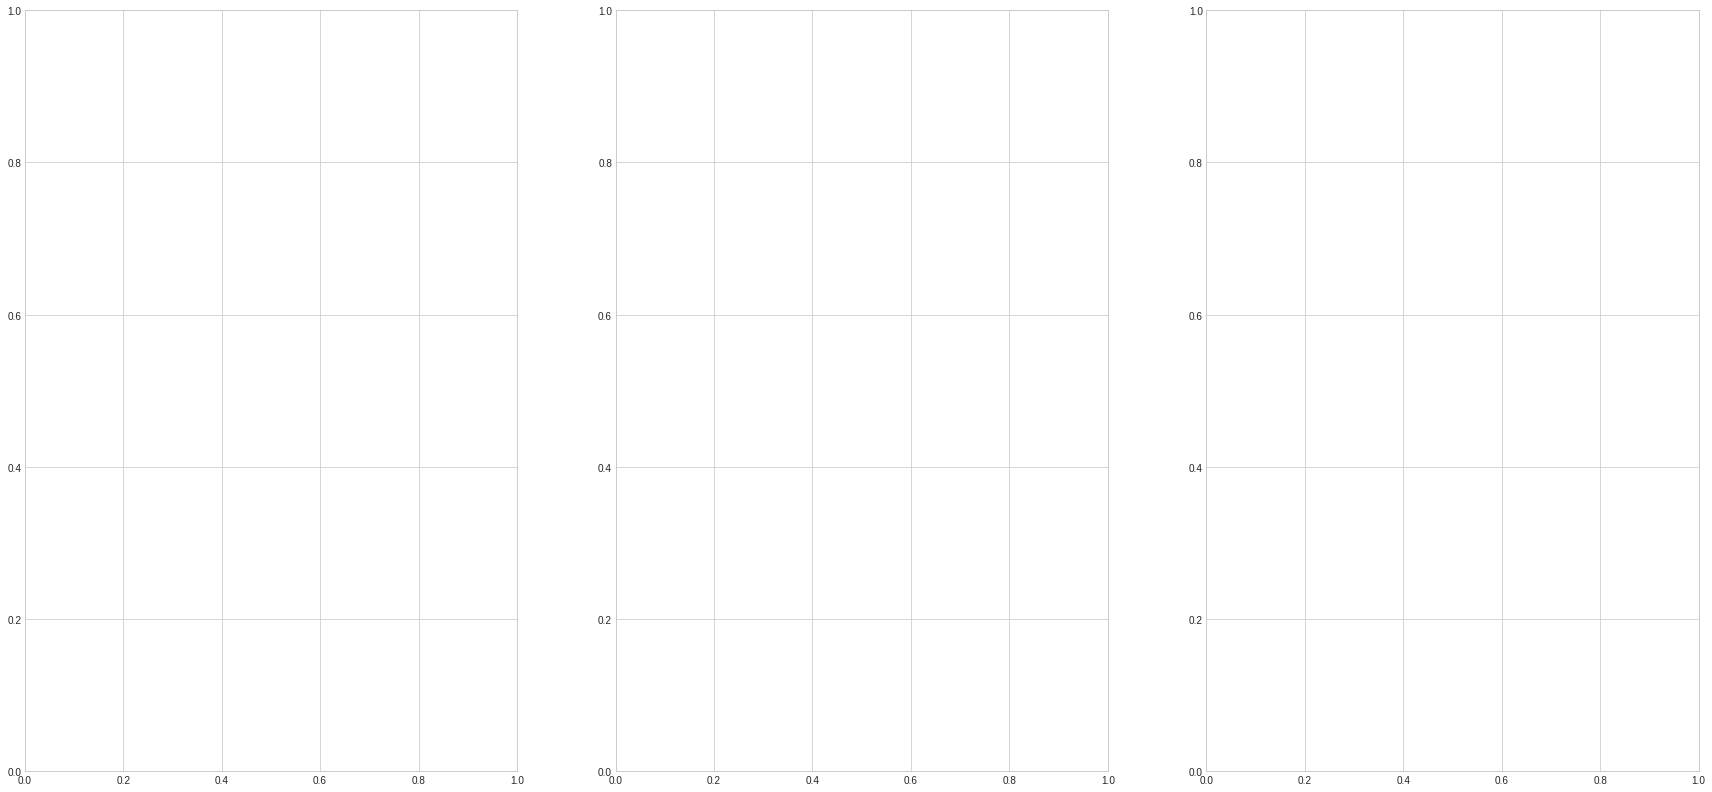

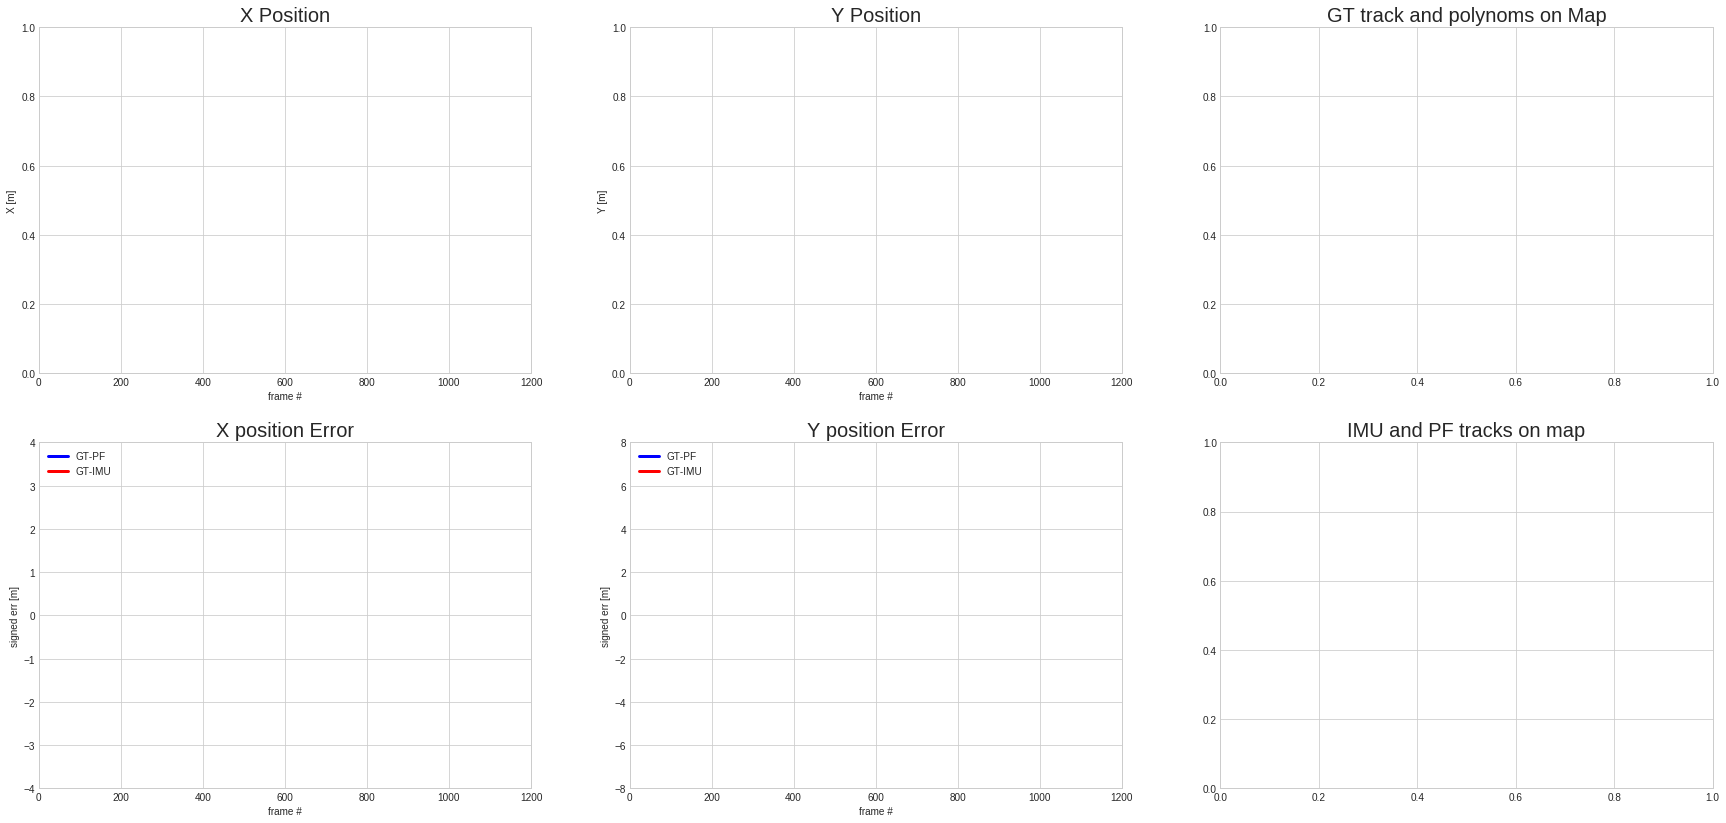

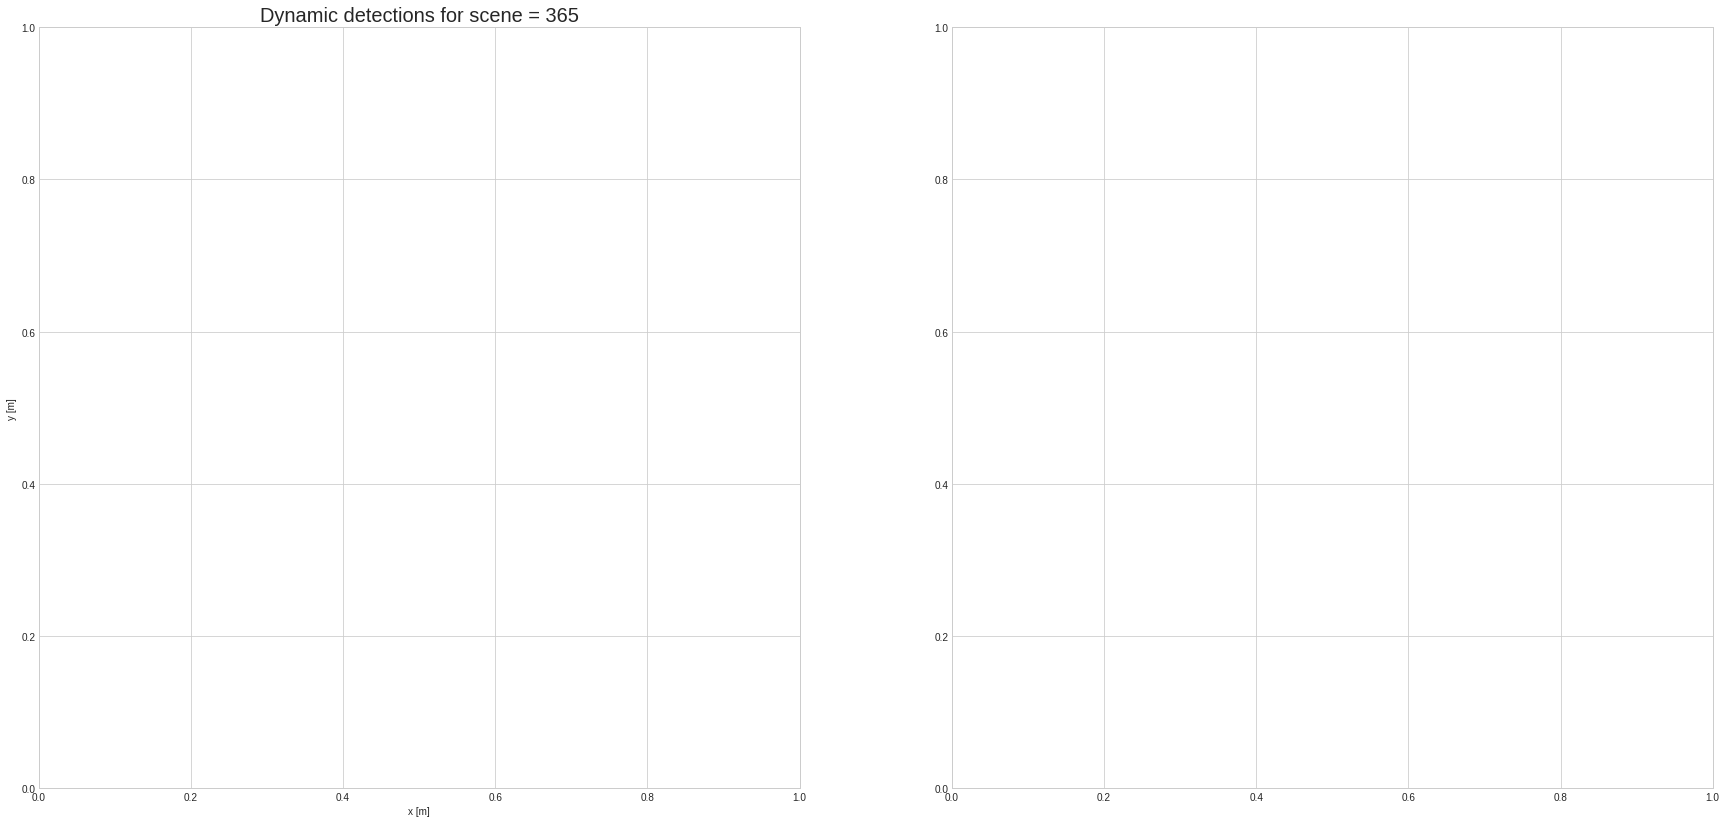

In [2]:
%load_ext autoreload
%autoreload 2
from simulation import NuscenesSimulation

class DummyModel():
    def __init__(self):
        self.mm = True
        
scene = 365
dummy_model = DummyModel()
video_list={'video' : False, 'video_debug': False, 'video_pf': False, 'video_pf_xy': False, 'dynamic_tracker': False}
sim = NuscenesSimulation(nusc=nusc, model=dummy_model, scene_id=scene, Nmax=1200, video_list=video_list, save_processed=True)

In [4]:
from database import NuscenesProcessedDatabase
data = NuscenesProcessedDatabase(scene_id=scene)


nusc_map = sim.dataset.nusc_map
video_with_priors = True

for t in range(0,10):
    img = sim.dataset.getSyncedImage(t)
    video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
    video_data["img"] = img

    sim.video_list["video"] = True
    sim.video_list["video_debug"] = True
    sim.video_list["video_pf"] = True
    sim.video_list["video_pf_xy"] = True
    sim.video_list["dynamic_tracker"] = True

    sim.drawPlots(t, video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, nusc_map, video_with_priors, translation, debug_info)

self.dir_name images/365/database
len(unique_polynoms) 0
PF RMSE lateral: 0.12485591499387513
PF RMSE longitudal: 0.2212173536445722
IMU RMSE lateral: 0.09131776510148713
IMU RMSE longitudal: 0.2212173536445722
len(unique_polynoms) 0
PF RMSE lateral: 0.10313275311846183
PF RMSE longitudal: 0.18062321289267283
IMU RMSE lateral: 0.07524269681863661
IMU RMSE longitudal: 0.18062321289267283
len(unique_polynoms) 0
PF RMSE lateral: 0.10356684481011537
PF RMSE longitudal: 0.15642429087821963
IMU RMSE lateral: 0.08088012941750138
IMU RMSE longitudal: 0.15642429087821963
len(unique_polynoms) 0
PF RMSE lateral: 0.10179688262779228
PF RMSE longitudal: 0.13991013909435976
IMU RMSE lateral: 0.08217886917046818
IMU RMSE longitudal: 0.13991013909435976
len(unique_polynoms) 0
PF RMSE lateral: 0.1106041393029429
PF RMSE longitudal: 0.12771989867611042
IMU RMSE lateral: 0.0925436347244202
IMU RMSE longitudal: 0.12771989867611042
len(unique_polynoms) 0
PF RMSE lateral: 0.11952121273190364
PF RMSE longitu